In [2]:
import logging
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [3]:
logging.info('Loading data sets')

train = pd.read_csv(r"..\data\train.csv",parse_dates = True, low_memory = False, index_col = 'Date')
store = pd.read_csv(r'..\data\store.csv',low_memory = False)
test = pd.read_csv(r'..\data\test.csv',low_memory = False)

logging.info('Loading data sets done.')

In [4]:
print("In total: ", train.shape)  # In total:  (1017209, 8)
train.head(5).append(train.tail(5))

In total:  (1017209, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1
2013-01-01,1111,2,0,0,0,0,a,1
2013-01-01,1112,2,0,0,0,0,a,1
2013-01-01,1113,2,0,0,0,0,a,1
2013-01-01,1114,2,0,0,0,0,a,1


In [5]:
# data extraction
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

In [6]:
# adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()



count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

Text(0.5, 0, 'Sale per Customer')

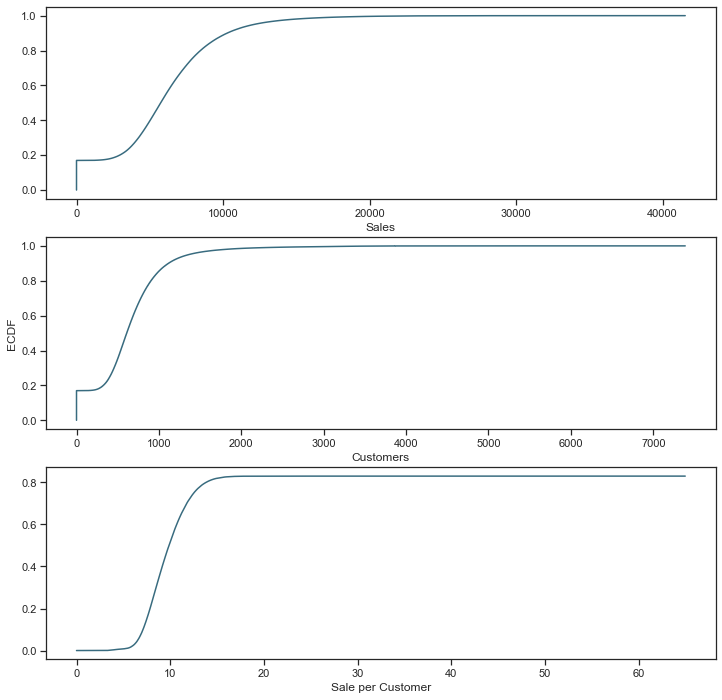

In [7]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 12))

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c)
plt.xlabel('Sales')

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c)
plt.xlabel('Customers')
plt.ylabel('ECDF')

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c)
plt.xlabel('Sale per Customer')


Approximately 20% of the data requires us to process zero sales and customer numbers
And almost 80% of the time, the number of sales per day is less than 1,000

In [8]:
# closed stores
train[(train.Open == 0) & (train.Sales == 0)].head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN


A sample of stores that were closed and had zero sales.Since we want to predict future sales, these zero values are not helpful for predicting trends, so they are directly discarded during preprocessing

In [9]:
len(train[(train.Open == 0) & (train.Sales == 0)])  # 172817

172817

This accounts for almost 17% of the total number of stores

In [10]:
# opened stores with zero sales
zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
print("In total: ", zero_sales.shape)  # (54, 13)
zero_sales.head(5)


In total:  (54, 13)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1,2015,5,15,20,NaN
2015-03-26,674,4,0,0,1,0,0,0,2015,3,26,13,NaN
2015-02-05,699,4,0,0,1,1,0,0,2015,2,5,6,NaN
2014-10-01,708,3,0,0,1,1,0,0,2014,10,1,40,NaN
2014-09-22,357,1,0,0,1,0,0,0,2014,9,22,39,NaN


54 stores were open but had zero sales

In [11]:
# missing values?
store.isnull().sum()


Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [12]:
# missing values in CompetitionDistance
store[pd.isnull(store.CompetitionDistance)]


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


This information is simply lost from the data. In this case, it makes perfect sense to replace NaN with the median.

Text(0.5, 1.0, 'Distribution of Store Competition Distance')

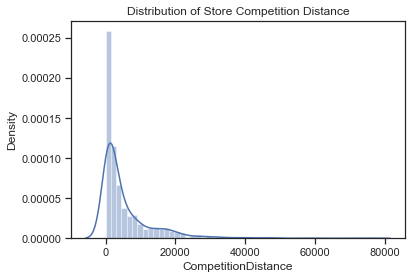

In [14]:
#Check distribution of Competition distance 
sns.distplot(store.CompetitionDistance.dropna())
plt.title("Distribution of Store Competition Distance")


In [15]:
# fill NaN with a median value because distribuion is skwewed
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

In [16]:
# replace NA's by 0
store.fillna(0, inplace = True)

In [17]:
print("Joining train set with an additional store information.")

# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

print("In total: ", train_store.shape)
train_store.head()

Joining train set with an additional store information.
In total:  (1017209, 22)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


Relationship between Sales and Store Type

In [18]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,551627.0,5738.179710,3964.028134,0.0,3508.0,5618.0,7860.00,41551.0
b,15830.0,10058.837334,5280.525506,0.0,6227.0,9025.5,13082.75,38722.0
c,136840.0,5723.629246,3721.700886,0.0,3789.0,5766.0,7849.00,31448.0
d,312912.0,5641.819243,3473.393781,0.0,3986.0,5826.0,7691.00,38037.0


StoreType B has the highest Sales average, but the data is much less

In [19]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()


,Customers,Sales
StoreType,,
a,363541434,3165334859
b,31465621,159231395
c,92129705,783221426
d,156904995,1765392943


Type a and d stores rank in the top two positions in both "Sales" and "Customers"

Relationship between Sales and Assortment

In [20]:
train_store.groupby('Assortment')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
Assortment,,,,,,,,
a,537445.0,5481.026096,3682.766186,0.0,3492.0,5463.0,7514.00,38722.0
b,8294.0,8553.931999,3882.418206,0.0,5523.0,8026.5,11233.25,22137.0
c,471470.0,6058.676567,3992.255662,0.0,4017.0,6039.0,8184.00,41551.0


Assortment Type b has the highest Average sales

In [21]:
train_store.groupby('Assortment')['Customers', 'Sales'].sum()

,Customers,Sales
Assortment,,
a,332766938,2945750070
b,16972525,70946312
c,294302292,2856484241


Assortment a has the largest number of Customers abd it's Sales are the heighst followed by Assortment c and Lastly b.

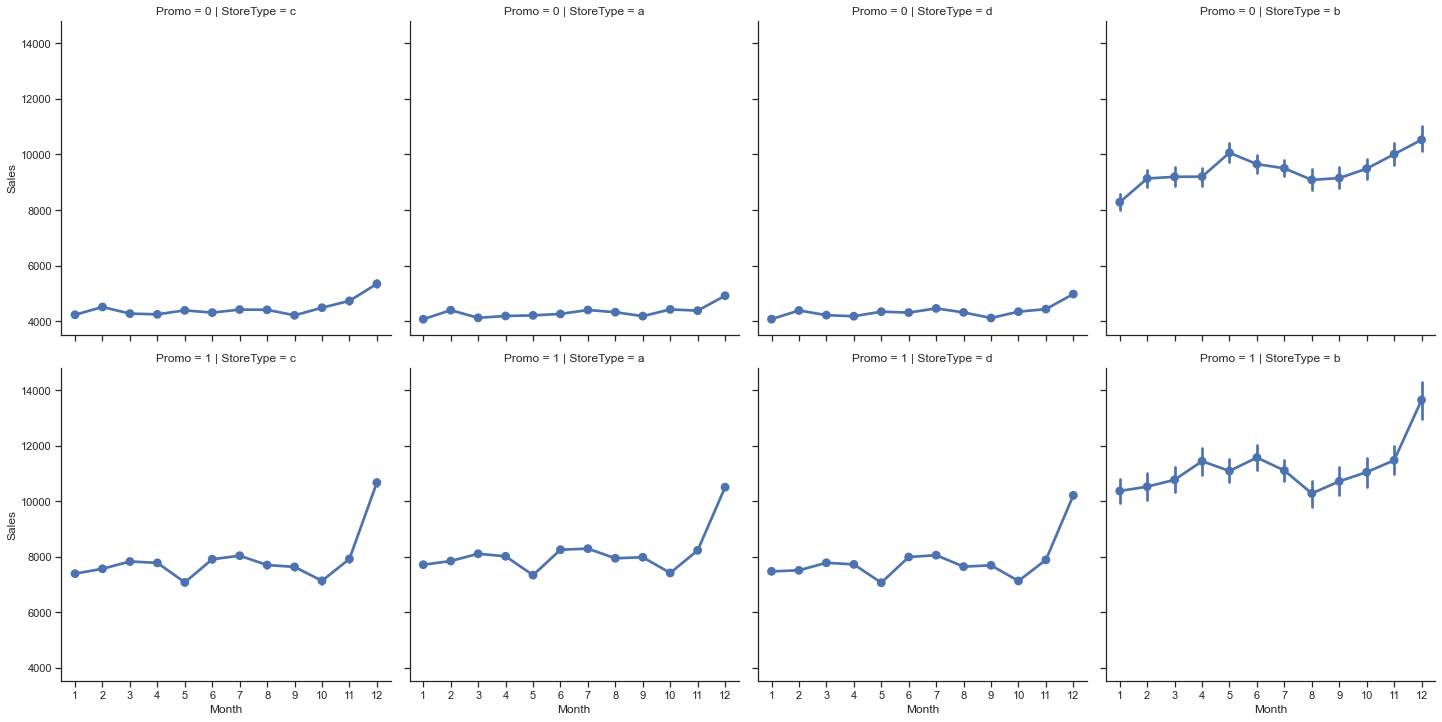

In [22]:
sns.factorplot(data = train_store, 
               x = 'Month', 
               y = 'Sales', 
               col = 'StoreType', # per store type in cols
               row = 'Promo', # per promo in the store in rows
               ) 


Generally,the number of sales increased in all the Store Types during promotion.However,the sales peaked in December.This maybe beause people are buying things in prepation for Christmas or New Year.

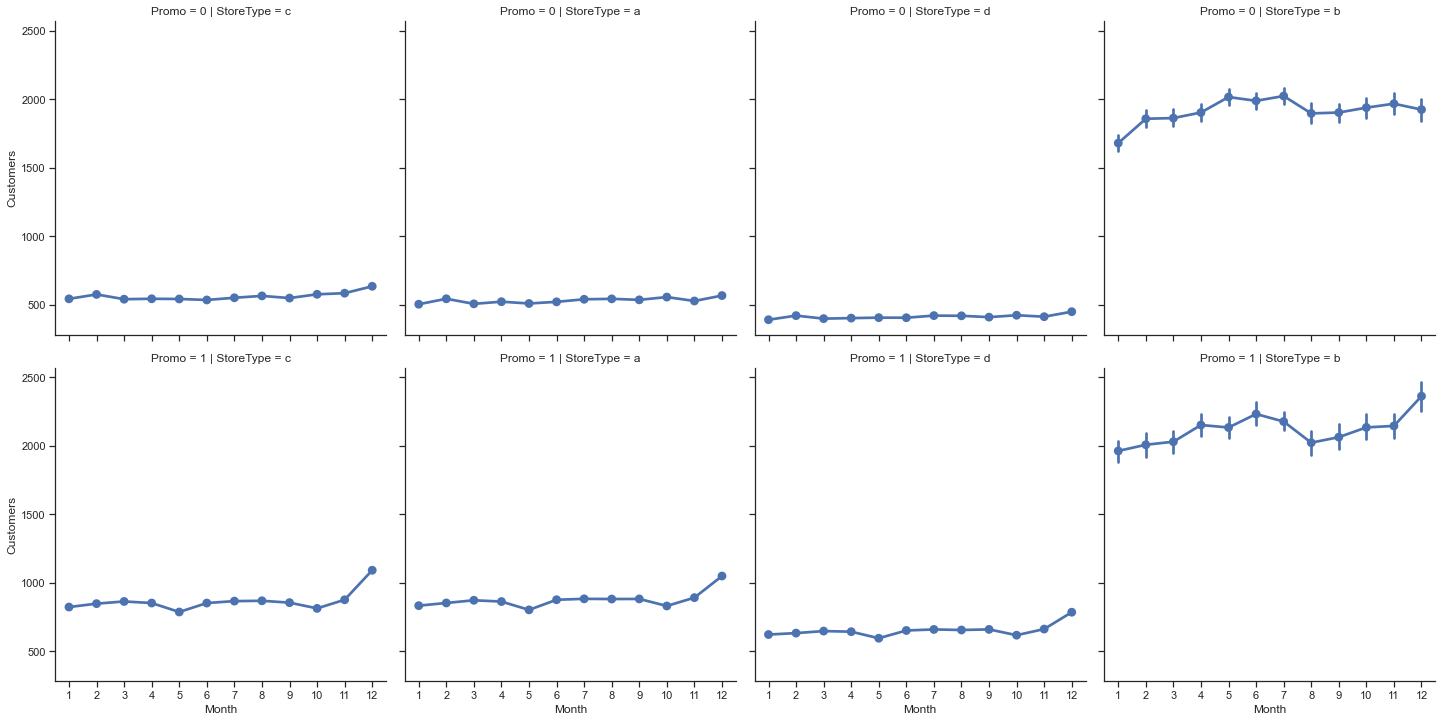

In [23]:
sns.factorplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'StoreType', # per store type in cols
               row = 'Promo'# per promo in the store in rows
              ) 


This shows that the number of Customers increased with the promotion.Although,the number of Customers peaked in December. This can be because people are buying goods in preparation for christmas or New Year.
The number of Customers in Store type D increased with the promo,although the increase was relatively small compared to other StoreTypes.

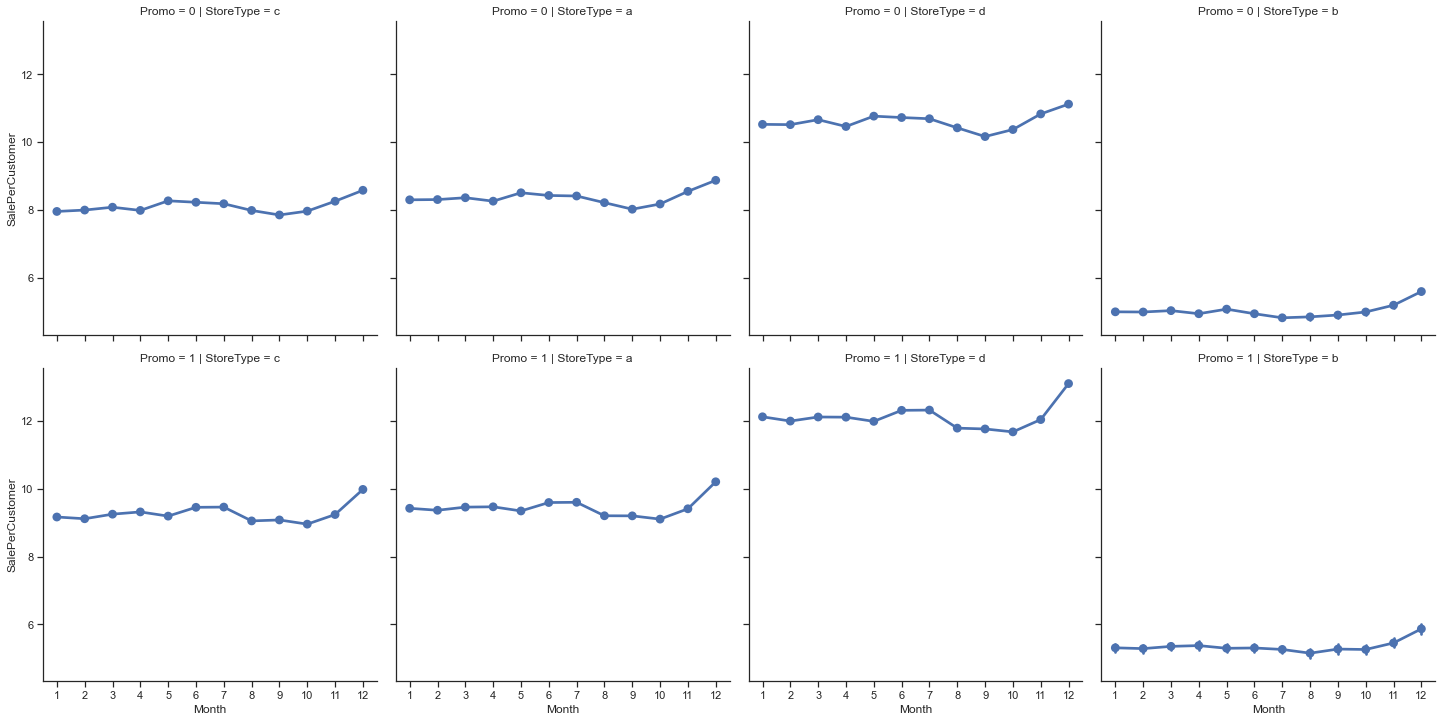

In [24]:
# sale per customer trends
sns.factorplot(data = train_store, x = 'Month', y = "SalePerCustomer", 
               col = 'StoreType', # per store type in cols
               row = 'Promo'# per promo in the store in rows
              ) 


During the promo,the average amount a customer spends increased.The amount peaked in December.
The Store Type D had a realatively small increased in comparison to other store Types.

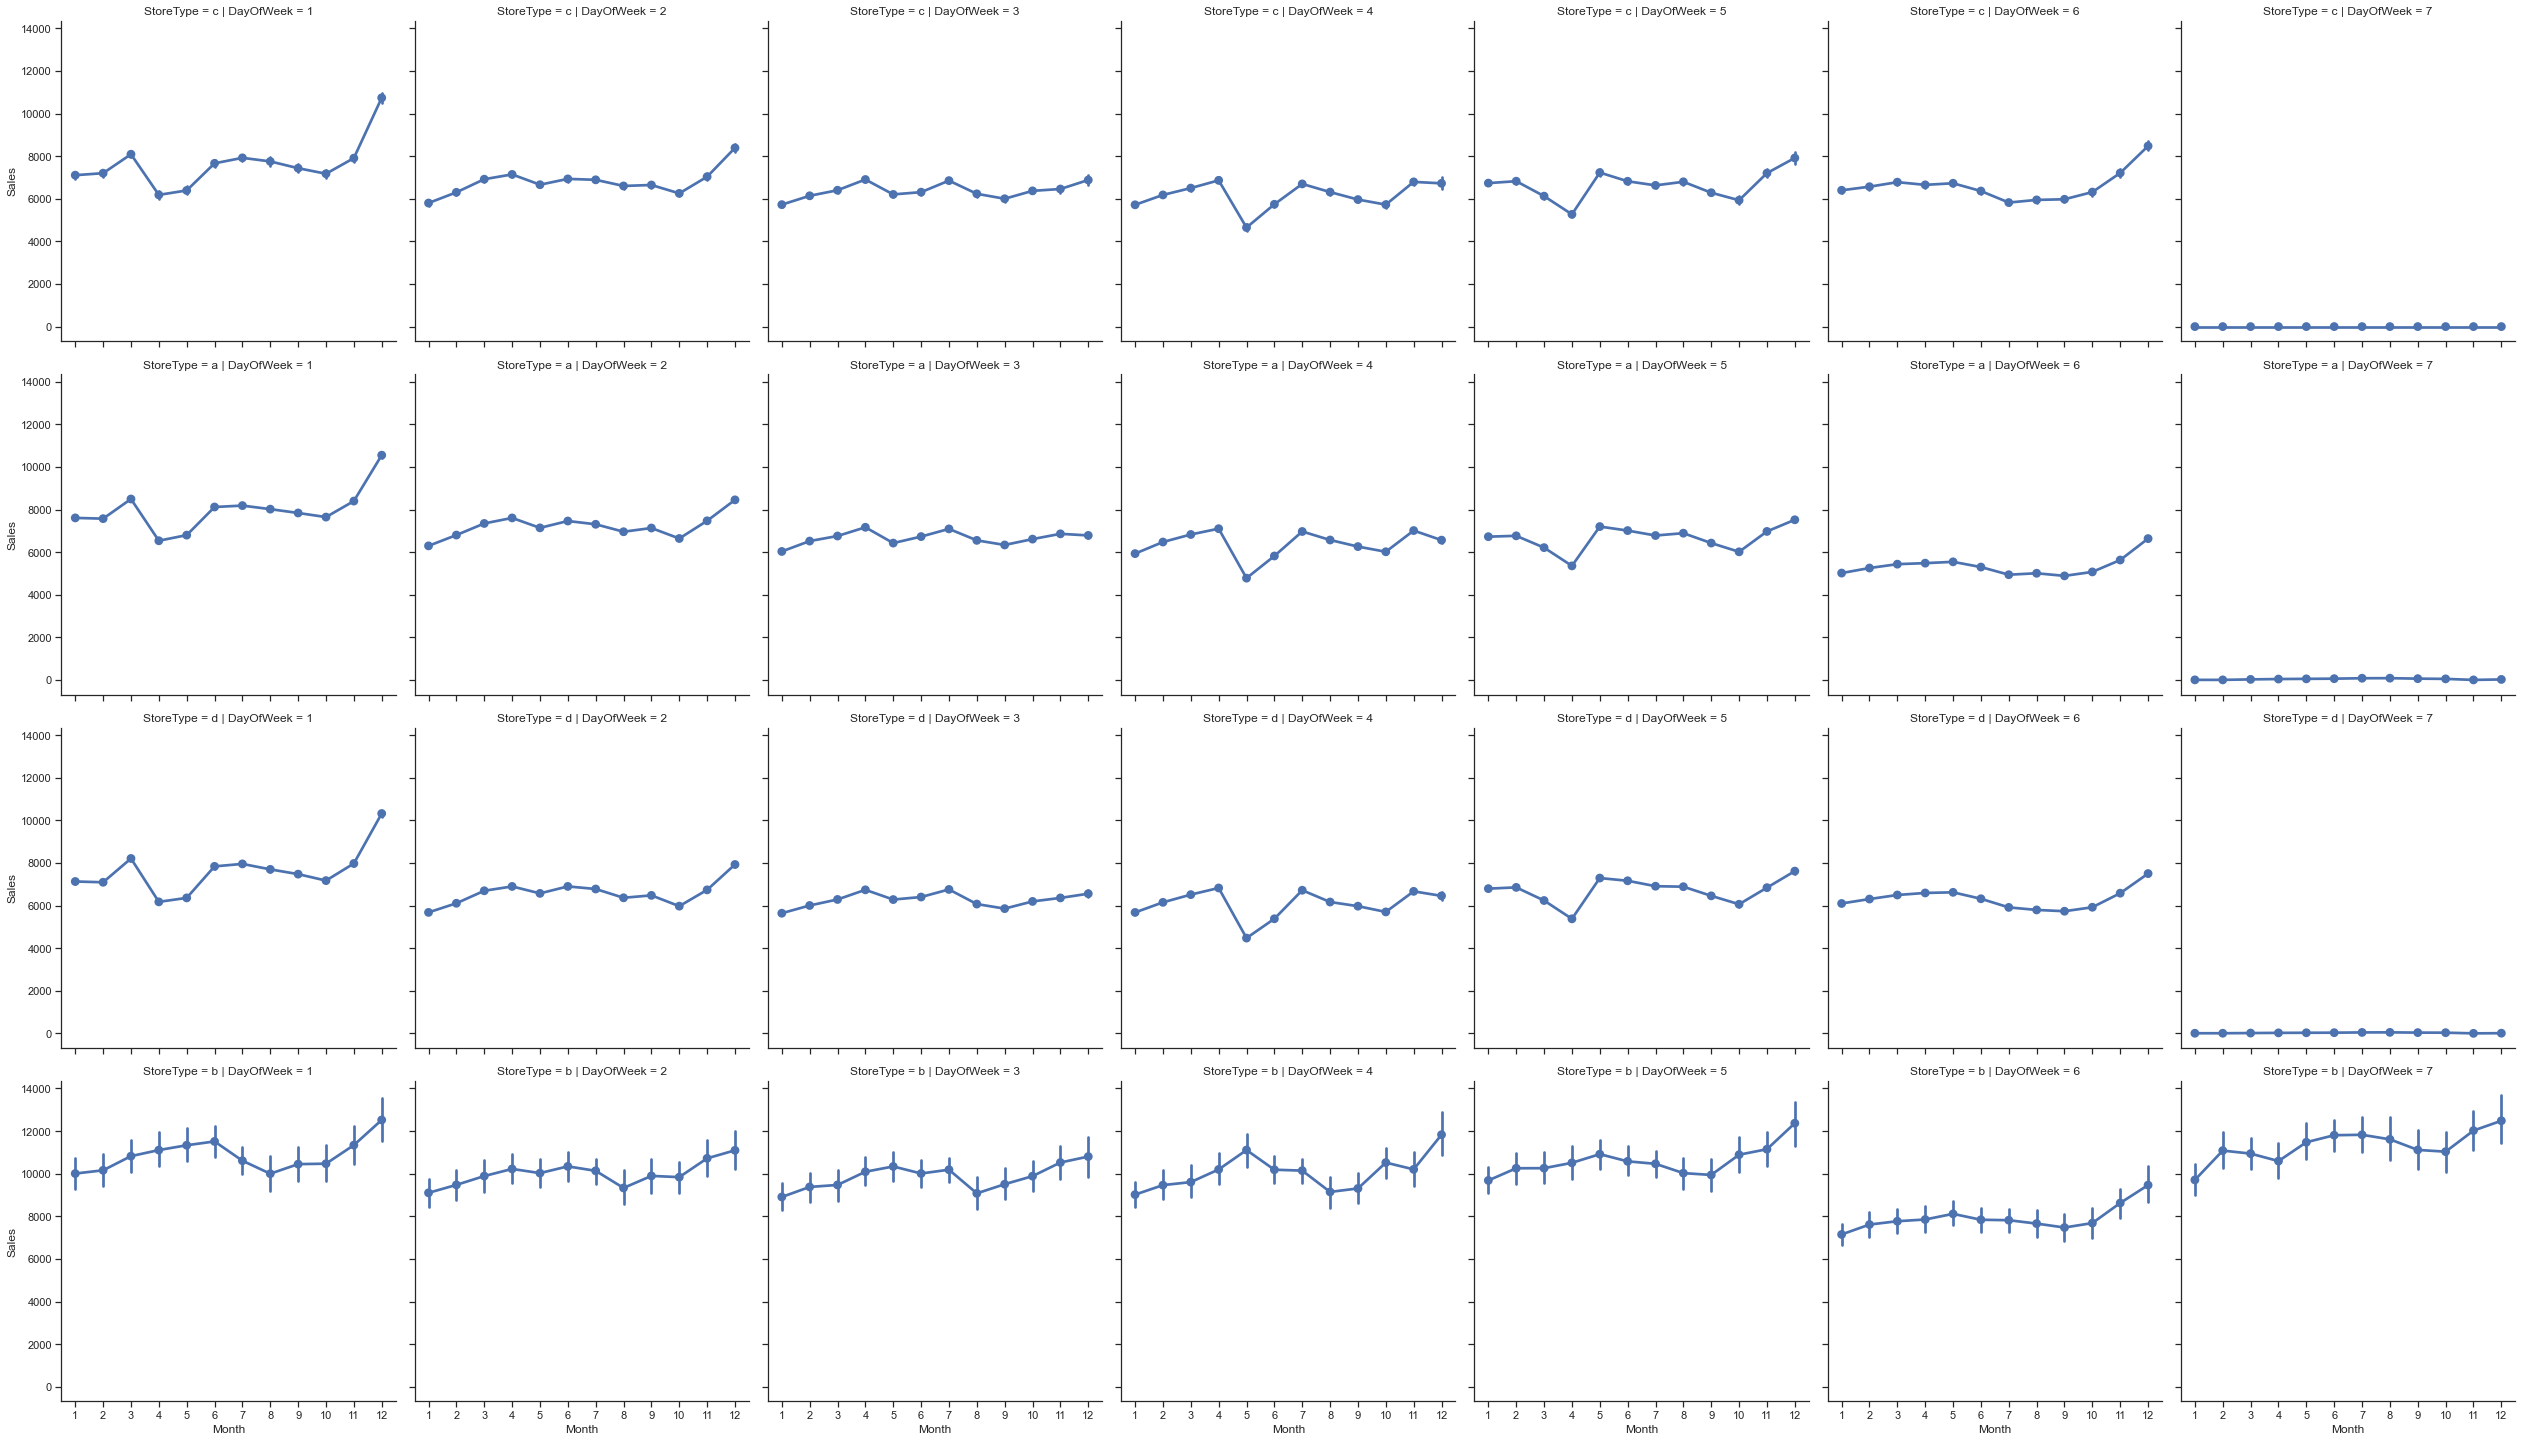

In [25]:
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', # per store type in cols
               row = 'StoreType', # per store type in rows
              ) 


On the 5th day(Friday) of the week in the 4th month(April), store Type C,A and D have a sharp decline in Sales while Store Type B increased in Sales.This can be beause the Easter holiday in April that raised the sales of the Stores(A,C a)
This trend can also be seen in the 4th day(Thursday) of the week in the 5th month(May).

On the 7th day(Sunday) of the week,number of sales in Store Type C,A and D tremendously decreased while the sales for Store Type B increased.This can be because Store Types C,A and D do not open on the 7th day(Sunday)

In [26]:
# stores which are opened on Sundays
train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()


array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099],
      dtype=int64)

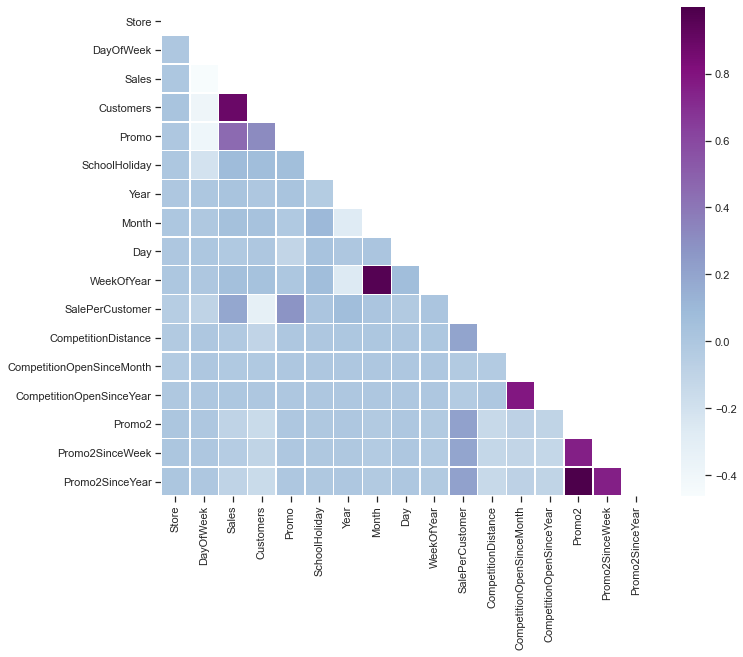

In [27]:
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = train_store.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()


From the Correlation Matrix,it shows that Sales and Customers are strongly related(positive realtionship).
Sales and Promo are also relatively related(positive realtionship).
The matrix shows that there is a very weak relationship between Sales and CompetetionDistance.

Seasonal
Four store types have been selected to represent their group.
1. Store Number 2 of StoreType A
2. The store number of StoreType B is 85,
3. Store Number 1 of StoreType C
4. The store number of StoreType D is 13.

<AxesSubplot:xlabel='Date'>

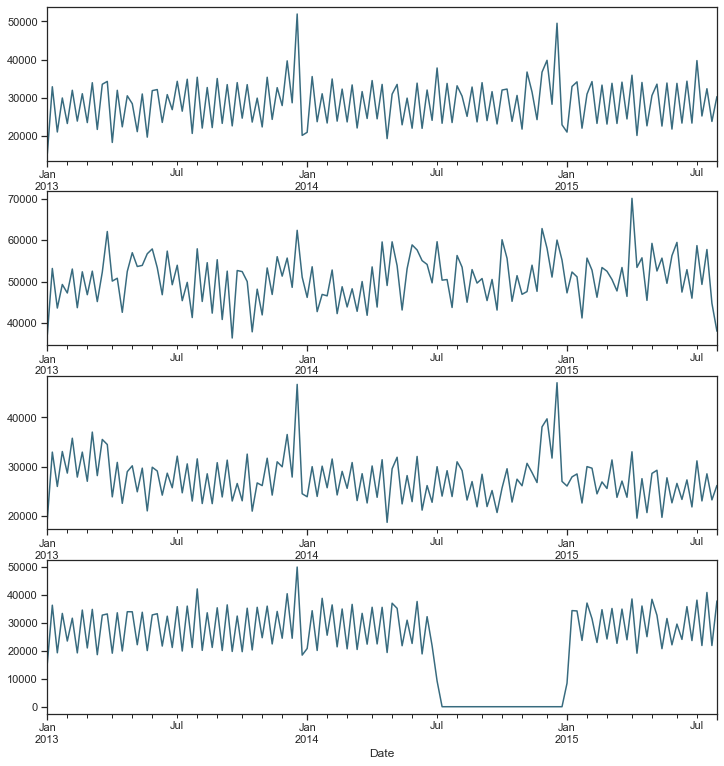

In [29]:
# preparation: input should be float type
train['Sales'] = train['Sales'] * 1.0

# store types
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) # solve the reverse order
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# store types
sales_a.resample('W').sum().plot(color = c, ax = ax1)
sales_b.resample('W').sum().plot(color = c, ax = ax2)
sales_c.resample('W').sum().plot(color = c, ax = ax3)
sales_d.resample('W').sum().plot(color = c, ax = ax4)


Store number 2 of Type A and store numner 1 of type C show a peak in Sales in December and a sharp drop in January after the holidays.There is no sales date for Store 13 of Type D from July 2014 to Jan 2015.

<AxesSubplot:xlabel='Date'>

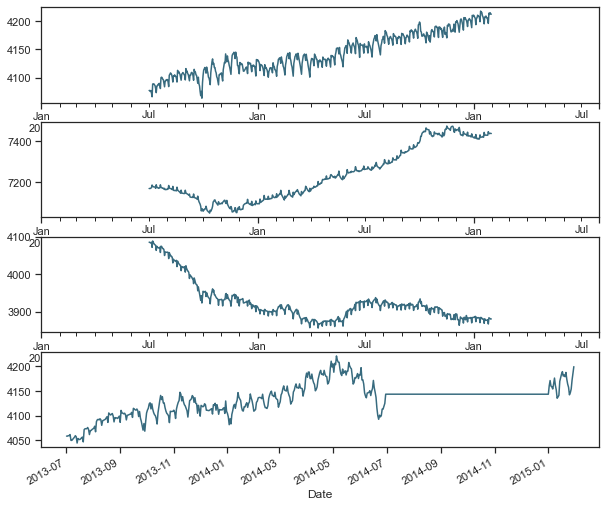

In [32]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (10, 9))

# monthly
decomposition_a = seasonal_decompose(sales_a, model = 'additive', freq = 365)
decomposition_a.trend.plot(color = c, ax = ax1)

decomposition_b = seasonal_decompose(sales_b, model = 'additive', freq = 365)
decomposition_b.trend.plot(color = c, ax = ax2)

decomposition_c = seasonal_decompose(sales_c, model = 'additive', freq = 365)
decomposition_c.trend.plot(color = c, ax = ax3)

decomposition_d = seasonal_decompose(sales_d, model = 'additive', freq = 365)
decomposition_d.trend.plot(color = c, ax = ax4)


Generaly, sales seem to have increased, but C has not. Although A is the best-selling store type in the dataset,
it seems to follow the same decreasing trajectory as C.
There is no data for Stor number 13 of Type D from July 2014 to January 2015. THis might be because the Store was clossed.

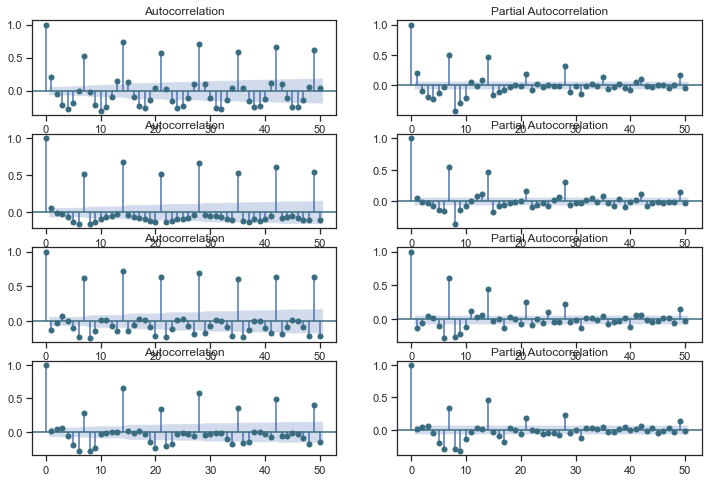

In [43]:
# figure for subplots
plt.figure(figsize = (12, 8))

# acf and pacf for A
plt.subplot(421); plot_acf(sales_a, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(sales_a, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for B
plt.subplot(423); plot_acf(sales_b, lags = 50, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(sales_b, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for C
plt.subplot(425); plot_acf(sales_c, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(sales_c, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for D
plt.subplot(427); plot_acf(sales_d, lags = 50, ax = plt.gca(), color = c)
plt.subplot(428); plot_pacf(sales_d, lags = 50, ax = plt.gca(), color = c)

plt.show()


Each level is a type of Store.
The features show the correlation of the sequence with it's own x time unit lag.
The pattern of the acf/pacf plot gives us an idea torwards which model would be best fit for doing prediction.